In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from functools import partial
from pathlib import Path
import torchvision

import math
import matplotlib.pyplot as plt
import re


from scripts.dataloader import Dataset, Transforms, Resize, ToTorch, Sampler, collate, DataLoader
from scripts.custom_models import Lambda, flatten, MixedInputModel, TabularModel, CNNModel, CustomResnet
from scripts.optimizer_and_loss import Optimizer, MSE_Loss, get_example_dataloaders, get_example_model
from scripts.callbacks import (Datablock, Callback, Learner, ParamSchedulerCallback, AvgStatsCallback, \
                               EarlyStoppingCallback, MoveBatchGPUCallback, BatchNumberCalculator, RecorderCallback,
                              sched_combiner, annealer, sched_lin, sched_cos, sched_none, sched_exp)

# Step 0 - Imports from previous lessons

The main things that we need from the previous lessons are the dattaloaders, the model, the loss function and the optimizer.  We don't need the training function because we will be rewriting it to include callbacks

In [3]:
dl_train, dl_valid = get_example_dataloaders()
model = get_example_model(dl_train)
loss_function = MSE_Loss(reduce = True)
opt = Optimizer(model, 0.02)

In [4]:
data = Datablock(dl_train, dl_valid)
metrics = []

pcts = [0.5, 0.5]
scheds = [sched_cos(0.4, 2), sched_cos(2, 0.4)]
sched_new = sched_combiner(pcts, scheds)

callbacks = [ParamSchedulerCallback('lr', sched_new), 
             EarlyStoppingCallback(10, 1), 
             AvgStatsCallback(metrics, metrics)]
callback_functions = [MoveBatchGPUCallback, BatchNumberCalculator, RecorderCallback]
learn = Learner(model = model, 
                data = data, 
                loss_func = loss_function, 
                opt = opt, cbs = callbacks, cbfs = callback_functions)


In [5]:
xb, yb = next(iter(dl_train))

# Step 1 - Introduction to Hooks

Our callback system provides a very flexible method of controlling training and extracting key metrics and parameters.  However, it does not allow us to control anything between batches or access layer-wise information.  We could program our own hook system by subclassing the nn.Sequential class, then changing the forward and initialization functions.

In [6]:
class HookedSequential(nn.Sequential):
    def __init__(self, *layers):
        super(HookedSequential, self).__init__()
        self.layers = nn.ModuleList(layers)
        self.means = [[] for _ in self.layers]
        self.stds = [[] for _ in self.layers]
        
    def __call__(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            self.means[i].append(x.data.mean())
            self.stds[i].append(x.data.std())
        return (x)
    

In [7]:
custom_resnet, tabular, mixed =  model.children()

In [8]:
new_model = HookedSequential(*[x for x in list(torchvision.models.resnet34(pretrained = True).children())[:-1]])

In [9]:
new_model(xb[0].float());

In [10]:
for m,s in zip(new_model.means, new_model.stds):
    print(m,s)

[tensor(-0.0075)] [tensor(0.7222)]
[tensor(0.1997)] [tensor(0.4112)]
[tensor(0.2654)] [tensor(0.2984)]
[tensor(0.3965)] [tensor(0.3806)]
[tensor(0.6047)] [tensor(0.5225)]
[tensor(0.2737)] [tensor(0.3327)]
[tensor(0.1195)] [tensor(0.2372)]
[tensor(0.9221)] [tensor(1.4329)]
[tensor(0.9221)] [tensor(0.7542)]


We now have a method of getting the output statistics from each of the layers during each pass.  If we run it over multiple batches, we can see how the stats change from batch to batch.

In [11]:
for i, (xb, yb) in enumerate(dl_train):
    new_model(xb[0].float())
    
    if i>4: break

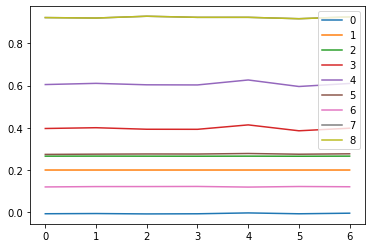

In [12]:
for means in new_model.means:
    plt.plot(means)
    plt.legend(range(len(new_model.means)))

What we can see is that we start with a mean of zero, but as we progress through the layers, the mean starts to approach 1. Since we aren't training, it's not surprising that the values aren't changing.   Once we train the model, we can see how things change over time.  Although we can certainly continue in this manner, Pytorch has its own system of callbacks called hooks.  

# Step 2 - Registering Pytorch Hooks

Pytorch hooks can be registered on any module and will call a function that takes the following three inputs:
- module
- the input to the layer
- the output to the layer

We will also add a hook input that we will discuss later.  For now, it does nothing in our function

In [13]:
base_model = torchvision.models.resnet34(pretrained = True)

In [14]:
layers_of_interest = list(base_model.children())

In [15]:
def output_mean(mod, inp, out):
    print(out.data.mean())
    
h1 = layers_of_interest[0].register_forward_hook(output_mean)

Now, when we run 

In [16]:
base_model(xb[0].float());

tensor(-0.0049)


It's important to note that these registered hooks persist, so if we register another one we'll actually end up running all of them.  If you keep running the cell below, the number of ouputs will gradually increase.

In [17]:
h2 = layers_of_interest[0].register_forward_hook(output_mean)
base_model(xb[0].float());

tensor(-0.0049)
tensor(-0.0049)


We can remove hooks using the class method .remove(), assuming we still have access to them!

In [18]:
h1.remove()
h2.remove()
base_model(xb[0].float());

With the hooks removed, we no longer print out the stats.  To make this process easier, we can create a hook class.  We can make the process even more flexible by passing the hook class itself into the forward hooks.  That allows us to store or access parameter from the hook using the hook function.  The hook function requires us to consider as inputs:
- module
- the input to the layer
- the output to the layer

Our functions will required:
- hook
- module
- the input to the layer
- the output to the layer

with the hook being built in usign `partial`


In [19]:
#export
class Hook():
    def __init__(self, module, hook_function):
        self.hook = module.register_forward_hook(partial(hook_function, self))
    def remove(self):
        self.hook.remove()
    def __del__(self):
        self.remove()

In [20]:
def output_mean_hook(hook, mod, inp, out):
    print(out.data.mean())

h1 = Hook(layers_of_interest[0], output_mean_hook)

In [21]:
h1.remove()

We can now create a manager to store all of our hooks.  It's easier if we have a built in method to add the hooks when we want them and remove them otherwise.  This can be achieved using a context manager through defining the `__enter__` and `__exit__` dunder methods

In [22]:
#export
class Hooks():
    def __init__(self, layers, hook_func):
        self.layers = layers
        self.hook_func = hook_func
        self.hooks = []
        
    def __enter__(self): 
        self.hooks = [Hook(layer, self.hook_func) for layer in self.layers]
        return self
        
    def __exit__(self, exception_type, exception_value, traceback):  
        if exception_type: print(exception_type, exception_value, traceback)
        self.remove()
        
    def __del__(self):   self.remove()
        
    def remove(self):
        for h in self.hooks: h.remove()
            
    def __len__(self): return len(self.hooks)
    
    def __getitem__(self, k): return self.hooks[k]
        

When we run the model under the context of the hook manager, the means are printed

In [23]:
with Hooks(layers_of_interest, output_mean_hook) as hks:
    base_model(xb[0].float())

tensor(-0.0049)
tensor(0.1997)
tensor(0.2655)
tensor(0.3979)
tensor(0.6099)
tensor(0.2765)
tensor(0.1203)
tensor(0.9253)
tensor(0.9253)
tensor(2.2256e-05)


Now when we run the model without the Hooks context, nothing is printed

In [24]:
base_model(xb[0].float());

Now that we have the hook manager that appears to be working, we should create a more interesting hook class.  What we really want to do is to store the values for the mean and standard deviation for out layers of choice.

In [25]:
def append_stats_basic(hook, mod, inp, out):
    if not hasattr(hook, 'stats'): hook.stats = [[],[]]
    means, stds = hook.stats
    means.append(out.data.mean())
    stds.append(out.data.mean())

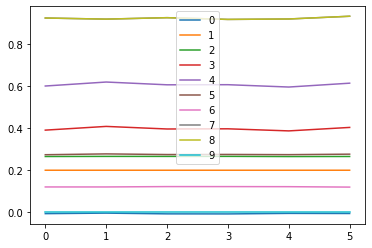

In [26]:
with Hooks(layers_of_interest, append_stats_basic) as hooks:
    #run a few batches
    for i, (xb, yb) in enumerate(dl_train):
        base_model(xb[0].float())
        if i>4: break
            
    #plot the results from each hook
    for hook in hooks:
        plt.plot(hook.stats[0])
        plt.legend(range(len(hooks)))

# Step 3 - Getting our list of layers

The example above has a very simple structure.  There are more than 9 layers in the network, but they have been divided into 9 distinct children.  

In [27]:
for i, child in enumerate(base_model.children()):
    print(i, child, '\n')

0 Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) 

1 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) 

2 ReLU(inplace=True) 

3 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False) 

4 Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), paddin

Is it important for you to track every single layer, or just the important ones?  With this model, we seem to have some nice divisions, but at the same time the first 4 layers are each a single module while the 5th one  is a whole block of sequential.  If we look at our mixed model, we see that the top layer only has three children:
1. Our custom resnet
2. The tabular model
3. The mixed input model (also tabular model)

In [28]:
for i, child in enumerate(model.children()):
    print(i, child, '\n')

0 CustomResnet(
  (model): Sequential(
    (0): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNo

If we want to get all of the children down to the individual nodes, we can use recursion.  We can also choose whether we want to include only the most basic layers (LInear, Conv2d, ReLU, etc.) or everything.  We need to be careful about the order here though.  If we access a more complicated layer (ex. Tabular model), that output will occur after all of the children have been executed, so it should be added to the list after all of the 

In [29]:
#export
def get_all_children(model, layers = [], base_only = True):
    children = list(model.children())
    
    #base case: no more children
    if len(children) == 0: layers.append(model)
    
    #recursive case
    else:
        for child in children:
            get_all_children(child, layers)
        if not base_only: layers.append(model)
    return layers
    

In [30]:
all_layers = get_all_children(model, base_only = True)
for layer in all_layers:
    print(layer._get_name(), layer)

Conv2d Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
BatchNorm2d BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU ReLU(inplace=True)
MaxPool2d MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
Conv2d Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
BatchNorm2d BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU ReLU(inplace=True)
Conv2d Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
BatchNorm2d BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Conv2d Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
BatchNorm2d BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU ReLU(inplace=True)
Conv2d Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
BatchNorm2d BatchNorm2d(64, eps=1e-05, momentum=0.1

For our example, we can 

child._get_name()

In [31]:
filtered_layers = [x for x in all_layers if x._get_name()=='ReLU']
len(filtered_layers)

22

6
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
6
6
6
6
6


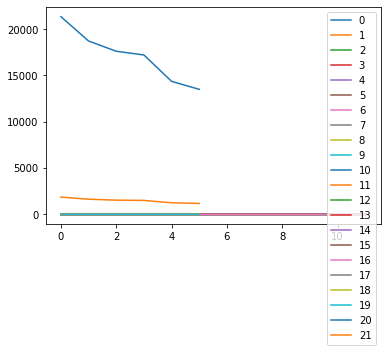

In [35]:
with Hooks(filtered_layers, append_stats_basic) as hooks:
    #run a few batches
    for i, (xb, yb) in enumerate(dl_train):
        model(xb)
        if i>4: break
            
    #plot the results from each hook
    for hook in hooks:
        plt.plot(hook.stats[0])
        plt.legend(range(len(hooks)))

We have a very interesting result: after training for 6 batches, some layers have 6 items in their means list and others have 12.  What can explain this?  It seems like the layers with 12 are from the Resnet model.  My best guess is that specific ReLU class instances are being used twice in a module.  Although this is not an issue in terms of the forwards or reverse passes (there are no trainable parameters), it does make the interpretation slightly more difficult.  We can test this theory by looking at only the Conv2d layers.

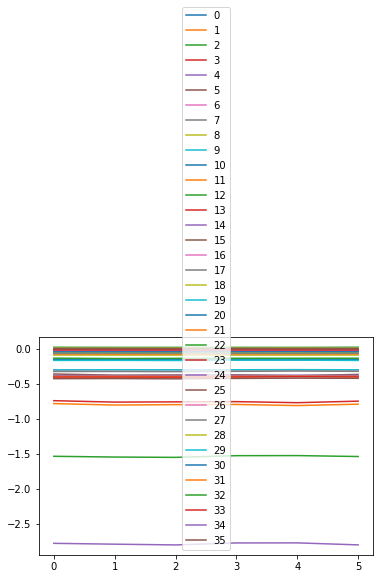

In [41]:
conv_layers = [x for x in all_layers if x._get_name()=='Conv2d']

with Hooks(conv_layers, append_stats_basic) as hooks:
    #run a few batches
    for i, (xb, yb) in enumerate(dl_train):
        model(xb)
        if i>4: break
            
    #plot the results from each hook
    for hook in hooks:
        plt.plot(hook.stats[0])
        plt.legend(range(len(hooks)))

Here we see that they all have 6 items, as expected.  Interestingly, the numbers appear to get progressively more negative as the layers get deeper.  Since we are using a ReLU activation, that also explains why everything tends towards the negative.  However, this graph is getting cluttered so it's difficult to interpret.  We may be better served by presenting this data as a histogram.  We will be remake our append_stats hook function to be a little more flexible.  The major changes are to move the outputs to the cpu (this way they'll work even when we move everything to the GPU), and to add a histogram stat.  This will allow us to observe how the distribution of values changes from batch to batch, or layer to layer

In [51]:
#export
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds .append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40,0,10))
    


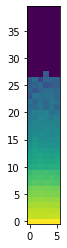

In [56]:
with Hooks(conv_layers, append_stats_hist) as hooks:
    #run a few batches
    for i, (xb, yb) in enumerate(dl_train):
        model(xb)
        if i>4: break

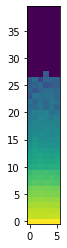

In [57]:
histogram = torch.stack(hooks[0].stats[2]).t().float().log1p()
plt.imshow(histogram, origin = 'lower')

## Final Notes

In [1]:
!python scripts/notebook2script.py "Part 5 - Pytorch Hooks.ipynb" 'hooks.py'

Converted Part 5 - Pytorch Hooks.ipynb to scripts\hooks.py
